In [23]:
import requests
import time
import json
import pandas as pd
import matplotlib.pyplot as plt

### total, influential citations

In [7]:
def get_citations(paper_id: str) -> tuple[int, int]:
    time.sleep(0.5)
    url = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}?fields=url,year,citationCount,influentialCitationCount"
    # headers = {"x-api-key": "XXXXXX"}
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    return (data["citationCount"], data["influentialCitationCount"])

In [27]:
dgidb_ids = [
    "f0e7a9a5b383994363aa4b68ed3509b082658e96",  # 5.0
    "749ad05a40f668e597faa60a815aded780224e4d",  # 4.0
    "47c27885c80ded97209f39e257ff6c4ab1eb34d6",  # 3.0
    "f23500ac9594a102f90da506368935bc8a769399",  # 2.0
    "4d5928aefcb2c4f7fcf420815bdb8c3628991e4f",  # 1.0
]

pharos_ids = [
    "0d32466f33173c8335765ded754ad62c5f484b03",  # 2023
    "8d2310e3a67d3344f7592fa304ee163435ecbcf1",  # 2021
    "7a2d1ac937efd5ecdaf3e47923a8b3ebb727953f",  # protocols
    "ca86314ac0b18d0ec9aded7377329e24b718d962",  # orig
]

ot_ids = [
    "1eb72ef89e6b7722e114e195f68cd45c86e6f344",  # 2023
    "38cf8d61e98d6263cf05a78a0f0712f56c802c46",  # 2020
    "4992d87ff038ae3bcdf8efdf805464d6f9db93a0",  # 2018
    "fc7b81e9a3c1552b846e6728cb28c14f75db6e08",  # 2016
]

In [14]:
dgidb_all = dgidb_infl = pharos_all = pharos_infl = ot_all = ot_infl = 0

for dgidb_id in dgidb_ids:
    cites_all, cites_infl = get_citations(dgidb_id)
    dgidb_all += cites_all
    dgidb_infl += cites_infl

for pharos_id in pharos_ids:
    cites_all, cites_infl = get_citations(pharos_id)
    pharos_all += cites_all
    pharos_infl += cites_infl

for ot_id in ot_ids:
    cites_all, cites_infl = get_citations(ot_id)
    ot_all += cites_all
    ot_infl += cites_infl

print((dgidb_all, dgidb_infl))
print((pharos_all, pharos_infl))
print((ot_all, ot_infl))

(2115, 131)
(423, 28)
(1202, 74)


In [35]:
def get_all_citation_data(paper_id):
    step = 500
    all_citations = []
    offset = 0
    while True:
        time.sleep(0.25)  # or use API key to avoid throttling
        url = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}/citations?fields=intents,isInfluential,year&offset={offset}&limit={step}"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if not data.get('data'):
            break
        for cite in data['data']:
            all_citations.append({
                "is_methodology": "methodology" in cite.get('intents'),
                "is_background": "background" in cite.get('intents'),
                "is_influential": cite['isInfluential'],
                "year": cite['citingPaper']['year']
            })
        offset += step
    return all_citations

all_citation_metadata = {
    "dgidb": {
        "dgidb_5": get_all_citation_data(dgidb_ids[0]),
        "dgidb_4": get_all_citation_data(dgidb_ids[1]),
        "dgidb_3": get_all_citation_data(dgidb_ids[2]),
        "dgidb_2": get_all_citation_data(dgidb_ids[3]),
        "dgidb_1": get_all_citation_data(dgidb_ids[4]),
    }, 
    "pharos": {
        "pharos_2023": get_all_citation_data(pharos_ids[0]),
        "pharos_2021": get_all_citation_data(pharos_ids[1]),
        "pharos_prots": get_all_citation_data(pharos_ids[2]),
        "pharos_orig": get_all_citation_data(pharos_ids[3]),
    },
    "ot": {
        "ot_2023": get_all_citation_data(ot_ids[0]),
        "ot_2020": get_all_citation_data(ot_ids[1]),
        "ot_2018": get_all_citation_data(ot_ids[2]),
        "ot_2016": get_all_citation_data(ot_ids[3]),
    }
}

with open("data/semantic_scholar_citation_metadata.json", "w") as f:
    json.dump(all_citation_metadata, f)

In [5]:
with open("data/semantic_scholar_citation_metadata.json") as f:
    all_citation_metadata = json.load(f)


In [15]:
columns = {
    "source": [],
    "paper": [],
    "is_influential": [],
    "is_method": [],
    "is_background": [],
    "year": [],
}

for source_name, source_papers in all_citation_metadata.items():
    for source_paper_name, source_paper in source_papers.items():
        for paper_cite in source_paper:
            columns['source'].append(source_name)
            columns['paper'].append(source_paper_name)
            columns['is_influential'].append(paper_cite['is_influential'])
            columns['is_background'].append(paper_cite['is_background'])
            columns['is_method'].append(paper_cite['is_methodology'])
            columns['year'].append(paper_cite['year'])
df = pd.DataFrame(columns)

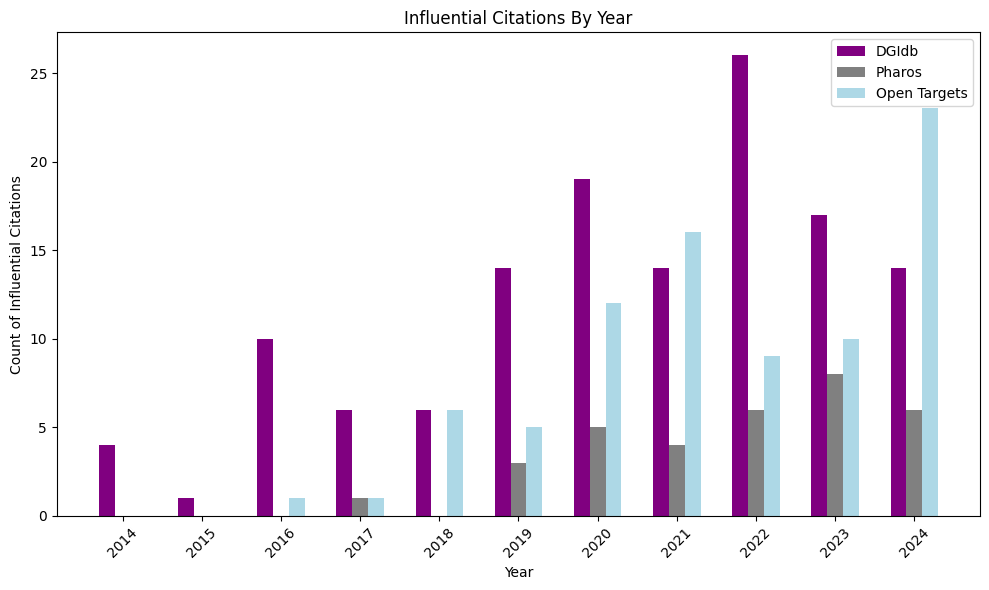

In [36]:
def influential_by_year(df: pd.DataFrame):

    df['is_influential'] = df['is_influential'].astype(int)  # Convert booleans to integers
    aggregated = df.groupby(['year', 'source'])['is_influential'].sum().reset_index()
    
    # Step 2: Pivot the data to create a grouped structure for plotting
    pivoted = aggregated.pivot(index='year', columns='source', values='is_influential').fillna(0)
    
    pivoted = pivoted.loc[pivoted.sum(axis=1) > 0]

    pivoted.rename(columns={"dgidb": "DGIdb", "ot": "Open Targets", "pharos": "Pharos"}, inplace=True)
    pivoted = pivoted[["DGIdb", "Pharos", "Open Targets"]]
    # Step 3: Plot grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = pivoted.index  # Years
    width = 0.2  # Width of bars
    source_names = pivoted.columns  # Source names
    n_sources = len(source_names)
    colors = ["purple", "grey", "lightblue"]
    # Generate bars for each source
    for i, source in enumerate(source_names):
        ax.bar(
            x + i * width - (n_sources - 1) * width / 2,  
            pivoted[source],
            width=width,
            label=source,
            color=colors[i],
        )  # TODO use better source names and use same colors

    # Customize plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Count of Influential Citations')
    ax.set_title('Influential Citations By Year')
    ax.set_xticks(x)
    ax.set_xticklabels(x.astype(int), rotation=45)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

influential_by_year(df)

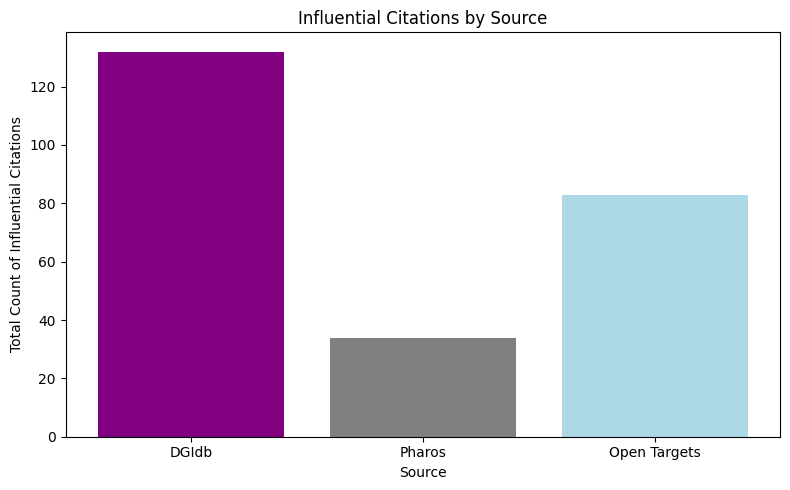

In [37]:
def influential_overall(df: pd.DataFrame):
    df['is_influential'] = df['is_influential'].astype(int)  # Convert booleans to integers
    aggregated = df.groupby(['source'])['is_influential'].sum().reset_index()

    # Rename sources for better readability
    aggregated['source'] = aggregated['source'].replace({
        "dgidb": "DGIdb",
        "ot": "Open Targets",
        "pharos": "Pharos"
    })

    # Reorder sources
    aggregated = aggregated.set_index('source').reindex(["DGIdb", "Pharos", "Open Targets"]).reset_index()

    # Plot a bar chart
    fig, ax = plt.subplots(figsize=(8, 5))

    sources = aggregated['source']
    counts = aggregated['is_influential']
    colors = ["purple", "grey", "lightblue"]

    ax.bar(sources, counts, color=colors)

    # Customize plot
    ax.set_xlabel('Source')
    ax.set_ylabel('Total Count of Influential Citations')
    ax.set_title('Influential Citations by Source')
    
    plt.tight_layout()
    plt.show()

# Example usage
influential_overall(df)
